In [1]:
# Initialize empty lists for each column
psnr = []
ssim = []
rmse = []
pcc = []

# Read the metrics file
with open("best results/metrics.txt", "r") as file:
    for line in file:
        # Skip comments and empty lines
        if line.startswith("#") or not line.strip():
            continue
        
        # Split the line into columns
        values = line.split()
        
        # Append values to respective lists
        psnr.append(float(values[0]))
        ssim.append(float(values[1]))
        rmse.append(float(values[2]))
        pcc.append(float(values[3]))

# Print the lists (optional)
print("PSNR:", psnr)
print("SSIM:", ssim)
print("RMSE:", rmse)
print("PCC:", len(pcc))

PSNR: [24.368145, 24.344346, 24.230811, 24.542954, 24.54737, 24.618962, 24.66876, 24.723905, 24.779014, 24.888343, 24.983426, 25.074105, 25.143001, 25.149169, 25.254973, 25.290279, 25.300225, 25.417198, 25.449319, 25.559479, 25.520704, 25.601992, 25.567769, 25.70774, 25.778707, 25.833366, 25.835667, 25.887976, 25.914721, 25.906188, 25.943344, 25.909817, 25.968661, 25.996478, 25.991566, 26.000379, 26.009974, 25.985758, 26.027237, 25.98669, 26.006502, 26.041364, 26.029155, 26.04764, 26.060585, 26.103537, 26.107702, 26.094348, 26.097395, 26.104703, 26.109395, 26.122062, 26.128918, 26.106991, 26.113802, 26.109197, 26.126649, 26.129911, 26.12403, 26.136071, 26.144566, 26.125209, 26.133517, 26.145564, 26.14984, 26.161787, 26.164125, 26.168499, 26.16329, 26.157111, 26.167246, 26.168487, 26.161002, 26.167049, 26.179816, 26.168934, 26.170066, 26.169636, 26.182733, 26.171799, 26.172552, 26.180508, 26.181635, 26.18056, 26.185091, 26.186299, 26.184862, 26.184293, 26.186637, 26.186564, 26.186807, 2

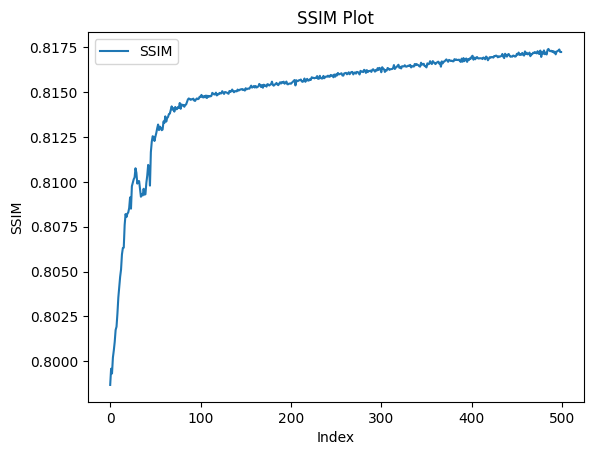

In [4]:
import matplotlib.pyplot as plt

# Normalize ssim to [0, 1]
normalized_ssim = [(x + 1) / 2 for x in ssim]

# Plot the normalized ssim
plt.plot(normalized_ssim, label="SSIM")
plt.xlabel("Index")
plt.ylabel("SSIM")
plt.title("SSIM Plot")
plt.legend()
plt.show()

Fitted params → L=1.0000, k=0.0047, x0=0.0


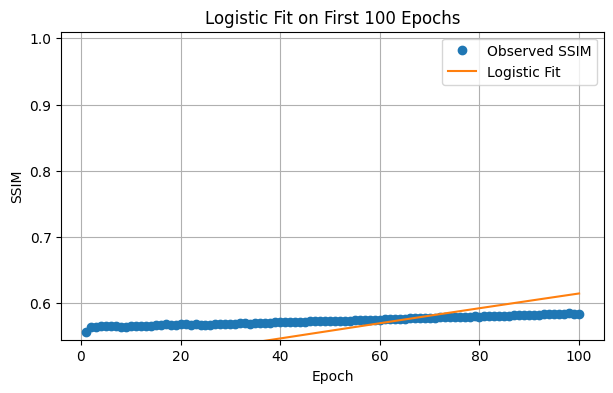

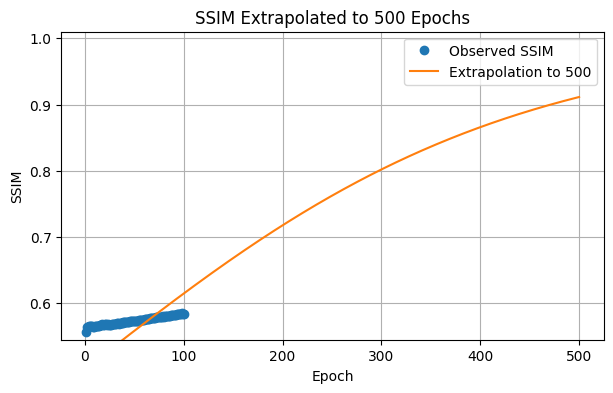

Predicted SSIM at 500 epochs: 0.9113


In [18]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# ─── your raw data ─────────────────────────────────────────────────────────────
# assume `ssim` is your Python list of SSIM values for epochs 1…N (e.g. N=100)
epochs = np.arange(1, len(ssim) + 1)
ssim_values = np.array(ssim)

# ─── logistic model ────────────────────────────────────────────────────────────
def logistic(x, L, k, x0):
    return L / (1 + np.exp(-k * (x - x0)))

# ─── dynamic bounds for L so p0 is always inside ───────────────────────────────
ssim_max = ssim_values.max()
eps = 1e-6
L_lower = min(ssim_max, 1.0 - eps)
if L_lower >= 1.0:
    L_lower = max(0.0, ssim_values.min() - eps)
bounds = (
    [L_lower, 0.001, 0.0],    # [L_min, k_min, x0_min]
    [1.0,     1.0,   len(epochs)*2]  # [L_max, k_max, x0_max]
)

# ─── initial guesses inside those bounds ───────────────────────────────────────
p0 = [
    ssim_max,           # L starts at observed max
    0.05,               # k = slow growth
    np.median(epochs)   # x0 ≈ halfway
]

# ─── fit to your first N epochs ────────────────────────────────────────────────
popt, _ = curve_fit(logistic, epochs, ssim_values, p0=p0, bounds=bounds, maxfev=10000)
L_fit, k_fit, x0_fit = popt
print(f"Fitted params → L={L_fit:.4f}, k={k_fit:.4f}, x0={x0_fit:.1f}")

# ─── plot fit on observed data ────────────────────────────────────────────────
plt.figure(figsize=(7,4))
plt.plot(epochs, ssim_values, 'o', label='Observed SSIM')
plt.plot(epochs, logistic(epochs, *popt), '-', label='Logistic Fit')
plt.xlabel('Epoch')
plt.ylabel('SSIM')
plt.ylim(ssim_values.min()*0.98, 1.01)
plt.title('Logistic Fit on First {} Epochs'.format(len(epochs)))
plt.legend()
plt.grid(True)
plt.show()

# ─── extrapolate to 500 epochs ────────────────────────────────────────────────
future_epochs = np.arange(1, 501)                 # change here: 1…500
predicted_ssim = logistic(future_epochs, *popt)

plt.figure(figsize=(7,4))
plt.plot(epochs, ssim_values, 'o', label='Observed SSIM')
plt.plot(future_epochs, predicted_ssim, '-', label='Extrapolation to 500')
plt.xlabel('Epoch')
plt.ylabel('SSIM')
plt.ylim(ssim_values.min()*0.98, 1.01)
plt.title('SSIM Extrapolated to 500 Epochs')
plt.legend()
plt.grid(True)
plt.show()

print(f"Predicted SSIM at 500 epochs: {predicted_ssim[-1]:.4f}")


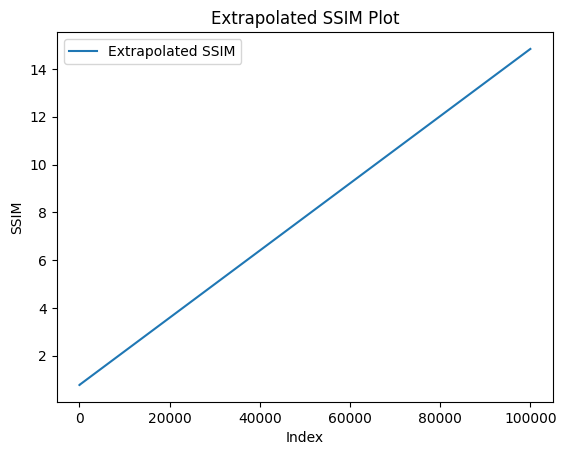

In [12]:
plt.plot(extrapolated_ssim, label="Extrapolated SSIM")
plt.xlabel("Index")
plt.ylabel("SSIM")
plt.title("Extrapolated SSIM Plot")
plt.legend()
plt.show()